In [1]:
import pickle
import glob
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from scipy.stats import pearsonr


## Shuffling Attention Heads by Layer

In [2]:
epoch_files = glob.glob("../../scripts/pkls/shuffle/*.pkl")

def get_aucs_list(share, layer):
    epoch_25 = []
    for item in epoch_files:
        if item.split("/")[5].split("_")[4] == str(share):
            epoch_25.append(item)
    for item in epoch_25:
        if item.split("/")[5].split("_")[1] == str(layer):
            with open(item, "rb") as f:
                aucs = pickle.load(f)
                print("100 epochs bootstrap CI for layer {}: [{}, {}]".format(layer,
                                                                 np.quantile(aucs, [0.025, 0.975])[0],
                                                                 np.quantile(aucs, [0.025, 0.975])[1]))
    return aucs

def read_json(full_path):
    """
    read json output files and store as pandas dataframe
    :param str full_path: the full path to the json file
    :param str file_type: 
    """
    df_con = pd.read_json(full_path, orient="records", lines=True)
    df_con.columns = ["file", "label", "control"]
    return df_con

def calculate_and_plot(res_path, train_auc):
    gpt_con = read_json("../cache-original/con_test.json")
    layers_files = glob.glob(res_path)
    for file in layers_files:
        new_column = file.split("/")[2]
        new_column = new_column.split("_")[:2]
        new_column = " ".join(new_column)
        with open(file, "r") as f:
            for line in f:
                data = json.loads(line)
                file_name = data["file"]
                gpt_con.loc[gpt_con["file"] == file_name, new_column] = data["perplexity"]
    con_perp = gpt_con["control"]
    test_accu = []
    test_auc = []
    for i in range(0, 12):
        column_name = "layer " + str(i)
        labels = gpt_con["label"].values.tolist()
        dem_perp = gpt_con[column_name]
        diff_perp = con_perp - dem_perp
        diff_perp = diff_perp.values.tolist()
        # false postive reate & true positive rate
        fpr, tpr, _ = roc_curve(labels, diff_perp)
        diff_auc = auc(fpr, tpr)
        test_auc.append(diff_auc)
        # false negative rate & true negative rate
        fnr = 1 - tpr
        tnr = 1 - fpr
        # calculate the prevalence of the positive class
        prevalence = np.count_nonzero(labels)/len(labels)
        # let's find the point on the ROC curve that corresponds to EER
        # where the diff between false native rate and false positive rate is the smallest
        eer_point = np.nanargmin(np.absolute((fnr - fpr)))
        # get TPR at EER
        tpr_at_eer = tpr[eer_point]
        # get TNR at EER
        tnr_at_eer = tnr[eer_point]
        # calculate accuracy based on TPR and TNR with known prevalnce of the positive class
        accuracy = tpr_at_eer * prevalence + tnr_at_eer * (1-prevalence)
        test_accu.append(accuracy)
    fpr, tpr, _ = roc_curve(gpt_con["label"].values.tolist(), gpt_con["control"].values.tolist())
    con_auc = auc(fpr, tpr)
    # false negative rate & true negative rate
    fnr = 1 - tpr
    tnr = 1 - fpr
    # calculate the prevalence of the positive class
    prevalence = np.count_nonzero(labels)/len(labels)
    # let's find the point on the ROC curve that corresponds to EER
    # where the diff between false native rate and false positive rate is the smallest
    eer_point = np.nanargmin(np.absolute((fnr - fpr)))
    # get TPR at EER
    tpr_at_eer = tpr[eer_point]
    # get TNR at EER
    tnr_at_eer = tnr[eer_point]
    # calculate accuracy based on TPR and TNR with known prevalnce of the positive class
    accuracy = tpr_at_eer * prevalence + tnr_at_eer * (1-prevalence)
    print(accuracy)
    plt.rcParams["figure.figsize"] = (20,5)
    plt.plot(list(range(0, 12)), [con_auc]*12, label="control")
    plt.plot(list(range(0, 12)), train_auc, label="c-d train")
    plt.plot(list(range(0, 12)), test_auc, label="c-d test")
    plt.xlabel("n-th layer")
    plt.ylabel("AUC")
    plt.title("AUC on Training and Test Set")
    plt.legend()
    plt.xticks(np.arange(0, 12, 1.0))
    for x, y in zip(list(range(0, 12)), train_auc):
        label = "{:.2f}".format(y)
        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,15), # distance from text to points (x,y)
                     ha='center')
    for x, y in zip(list(range(0, 12)), test_auc):
        label = "{:.2f}".format(y)
        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,15), # distance from text to points (x,y)
                     ha='center')
    plt.show()
    print("Pearson correction coeffificent: {}\np-value: {}".format(pearsonr(train_auc, test_auc)[0],
                                                                    pearsonr(train_auc, test_auc)[1]))

### Shuffling 25% Attention Heads

100 epochs bootstrap CI for layer 0: [0.5198216735253772, 0.6255486968449931]
100 epochs bootstrap CI for layer 1: [0.424528463648834, 0.5527263374485596]
100 epochs bootstrap CI for layer 2: [0.4231824417009603, 0.5811642661179699]
100 epochs bootstrap CI for layer 3: [0.4198988340192044, 0.5788323045267489]
100 epochs bootstrap CI for layer 4: [0.3399434156378601, 0.5015946502057612]
100 epochs bootstrap CI for layer 5: [0.4434156378600823, 0.6170353223593963]
100 epochs bootstrap CI for layer 6: [0.44441872427983536, 0.6506001371742112]
100 epochs bootstrap CI for layer 7: [0.37921810699588476, 0.5689986282578874]
100 epochs bootstrap CI for layer 8: [0.46632373113854597, 0.6859396433470508]
100 epochs bootstrap CI for layer 9: [0.46988168724279833, 0.6593364197530864]
100 epochs bootstrap CI for layer 10: [0.35988511659807954, 0.5726766117969821]
100 epochs bootstrap CI for layer 11: [0.4241941015089163, 0.5896604938271603]
0.75


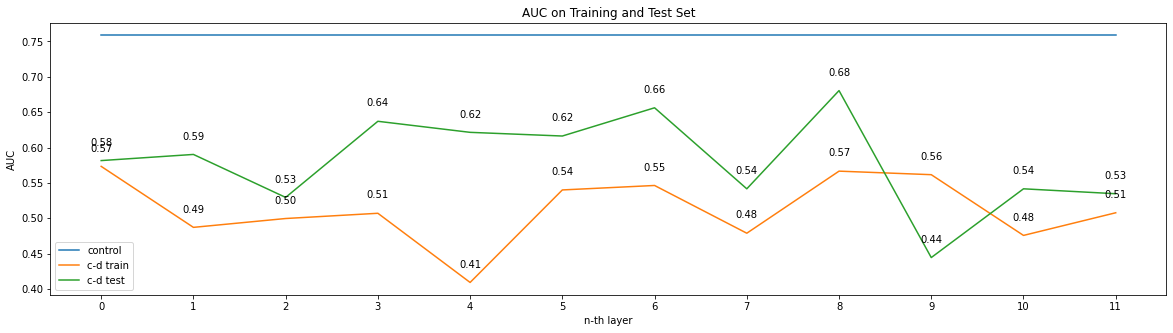

Pearson correction coeffificent: 0.03342945208471876
p-value: 0.9178546666468019


In [3]:
share = 25
layer0_25 = get_aucs_list(share, 0)
layer1_25 = get_aucs_list(share, 1)
layer2_25 = get_aucs_list(share, 2)
layer3_25 = get_aucs_list(share, 3)
layer4_25 = get_aucs_list(share, 4)
layer5_25 = get_aucs_list(share, 5)
layer6_25 = get_aucs_list(share, 6)
layer7_25 = get_aucs_list(share, 7)
layer8_25 = get_aucs_list(share, 8)
layer9_25 = get_aucs_list(share, 9)
layer10_25 = get_aucs_list(share, 10)
layer11_25 = get_aucs_list(share, 11)

train_auc_25 = [np.mean(layer0_25), np.mean(layer1_25), np.mean(layer2_25), np.mean(layer3_25), np.mean(layer4_25),
                np.mean(layer5_25), np.mean(layer6_25), np.mean(layer7_25), np.mean(layer8_25), np.mean(layer9_25),
                np.mean(layer10_25), np.mean(layer11_25)]
calculate_and_plot("../cache-epochs-100-share-25-style-shuffle/*.json", train_auc_25)

### Shuffling 50% Attention Heads

100 epochs bootstrap CI for layer 0: [0.4772976680384088, 0.6252829218106993]
100 epochs bootstrap CI for layer 1: [0.43795438957475996, 0.5720164609053499]
100 epochs bootstrap CI for layer 2: [0.4282407407407407, 0.5955589849108367]
100 epochs bootstrap CI for layer 3: [0.39963991769547325, 0.5612225651577504]
100 epochs bootstrap CI for layer 4: [0.3548696844993141, 0.4974365569272977]
100 epochs bootstrap CI for layer 5: [0.4260716735253772, 0.6148919753086419]
100 epochs bootstrap CI for layer 6: [0.468269890260631, 0.6678755144032922]
100 epochs bootstrap CI for layer 7: [0.3758316186556927, 0.5932613168724279]
100 epochs bootstrap CI for layer 8: [0.5055984224965706, 0.7516375171467764]
100 epochs bootstrap CI for layer 9: [0.422119341563786, 0.5700188614540466]
100 epochs bootstrap CI for layer 10: [0.39167524005486964, 0.5593792866941016]
100 epochs bootstrap CI for layer 11: [0.3703789437585734, 0.5658350480109738]
0.75


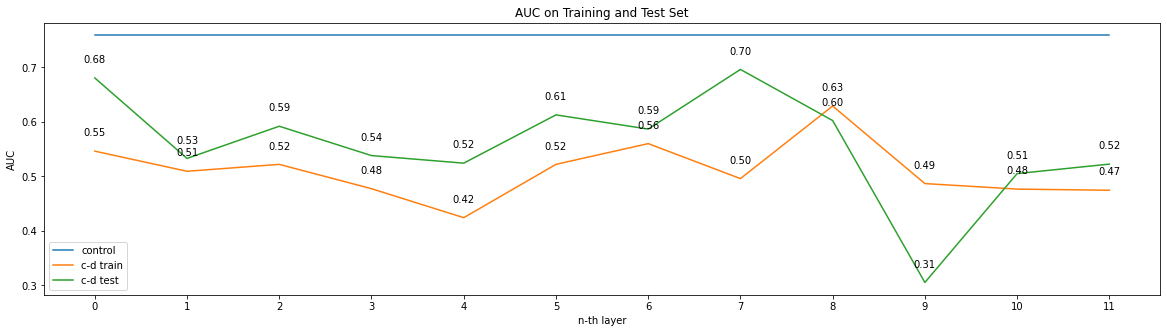

Pearson correction coeffificent: 0.3950975037684845
p-value: 0.20368012883793155


In [4]:
share = 50
layer0_50 = get_aucs_list(share, 0)
layer1_50 = get_aucs_list(share, 1)
layer2_50 = get_aucs_list(share, 2)
layer3_50 = get_aucs_list(share, 3)
layer4_50 = get_aucs_list(share, 4)
layer5_50 = get_aucs_list(share, 5)
layer6_50 = get_aucs_list(share, 6)
layer7_50 = get_aucs_list(share, 7)
layer8_50 = get_aucs_list(share, 8)
layer9_50 = get_aucs_list(share, 9)
layer10_50 = get_aucs_list(share, 10)
layer11_50 = get_aucs_list(share, 11)

train_auc_50 = [np.mean(layer0_50), np.mean(layer1_50), np.mean(layer2_50), np.mean(layer3_50), np.mean(layer4_50),
                np.mean(layer5_50), np.mean(layer6_50), np.mean(layer7_50), np.mean(layer8_50), np.mean(layer9_50),
                np.mean(layer10_50), np.mean(layer11_50)]
calculate_and_plot("../cache-epochs-100-share-50-style-shuffle/*.json", train_auc_50)

### Shuffling 100% Attention Heads

100 epochs bootstrap CI for layer 0: [0.5412294238683129, 0.6637774348422496]
100 epochs bootstrap CI for layer 1: [0.46105109739369, 0.6149777091906721]
100 epochs bootstrap CI for layer 2: [0.36382030178326474, 0.5594735939643346]
100 epochs bootstrap CI for layer 3: [0.4232767489711934, 0.6082133058984911]
100 epochs bootstrap CI for layer 4: [0.4015346364883402, 0.5823216735253771]
100 epochs bootstrap CI for layer 5: [0.40786179698216735, 0.5914008916323732]
100 epochs bootstrap CI for layer 6: [0.436059670781893, 0.6823388203017833]
100 epochs bootstrap CI for layer 7: [0.3788837448559671, 0.6428326474622771]
100 epochs bootstrap CI for layer 8: [0.3989883401920439, 0.5978737997256516]
100 epochs bootstrap CI for layer 9: [0.37692043895747596, 0.5143004115226336]
100 epochs bootstrap CI for layer 10: [0.35617283950617284, 0.5068501371742111]
100 epochs bootstrap CI for layer 11: [0.335125171467764, 0.487568587105624]
0.75


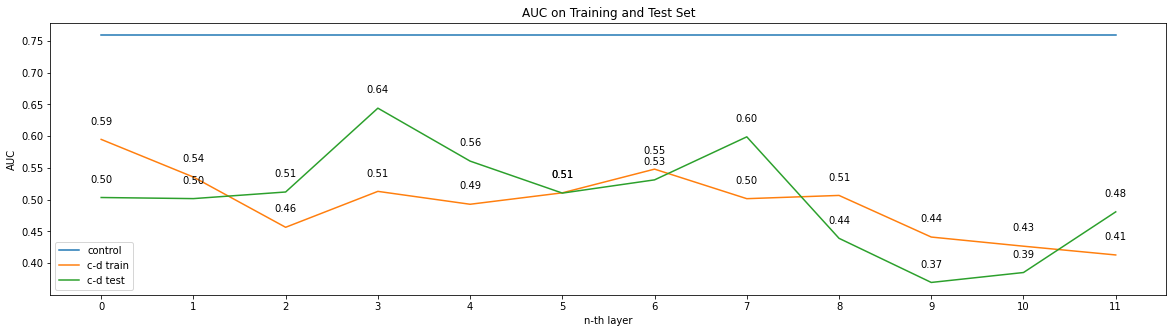

Pearson correction coeffificent: 0.44345343943738896
p-value: 0.14874975498950013


In [5]:
share = 100
layer0_100 = get_aucs_list(share, 0)
layer1_100 = get_aucs_list(share, 1)
layer2_100 = get_aucs_list(share, 2)
layer3_100 = get_aucs_list(share, 3)
layer4_100 = get_aucs_list(share, 4)
layer5_100 = get_aucs_list(share, 5)
layer6_100 = get_aucs_list(share, 6)
layer7_100 = get_aucs_list(share, 7)
layer8_100 = get_aucs_list(share, 8)
layer9_100 = get_aucs_list(share, 9)
layer10_100 = get_aucs_list(share, 10)
layer11_100 = get_aucs_list(share, 11)
train_auc_100 = [np.mean(layer0_100), np.mean(layer1_100), np.mean(layer2_100), np.mean(layer3_100), np.mean(layer4_100),
                 np.mean(layer5_100), np.mean(layer6_100), np.mean(layer7_100), np.mean(layer8_100), np.mean(layer9_100),
                 np.mean(layer10_100), np.mean(layer11_100)]
calculate_and_plot("../cache-epochs-100-share-100-style-shuffle/*.json", train_auc_100)

## Zeroing Attention Heads

In [8]:
epoch_files = glob.glob("../../scripts/pkls/zero/*.pkl")

### Zeroing 25% Attention Heads

100 epochs bootstrap CI for layer 0: [0.5706447187928669, 0.5706447187928669]
100 epochs bootstrap CI for layer 1: [0.5318930041152263, 0.5318930041152263]
100 epochs bootstrap CI for layer 2: [0.5041152263374485, 0.5041152263374485]
100 epochs bootstrap CI for layer 3: [0.5034293552812071, 0.5034293552812071]
100 epochs bootstrap CI for layer 4: [0.3611111111111111, 0.3611111111111111]
100 epochs bootstrap CI for layer 5: [0.5065157750342936, 0.5065157750342936]
100 epochs bootstrap CI for layer 6: [0.5089163237311385, 0.5089163237311385]
100 epochs bootstrap CI for layer 7: [0.45781893004115226, 0.45781893004115226]
100 epochs bootstrap CI for layer 8: [0.5641289437585734, 0.5641289437585734]
100 epochs bootstrap CI for layer 9: [0.5871056241426612, 0.5871056241426612]
100 epochs bootstrap CI for layer 10: [0.41872427983539096, 0.41872427983539096]
100 epochs bootstrap CI for layer 11: [0.5243484224965707, 0.5243484224965707]
0.75


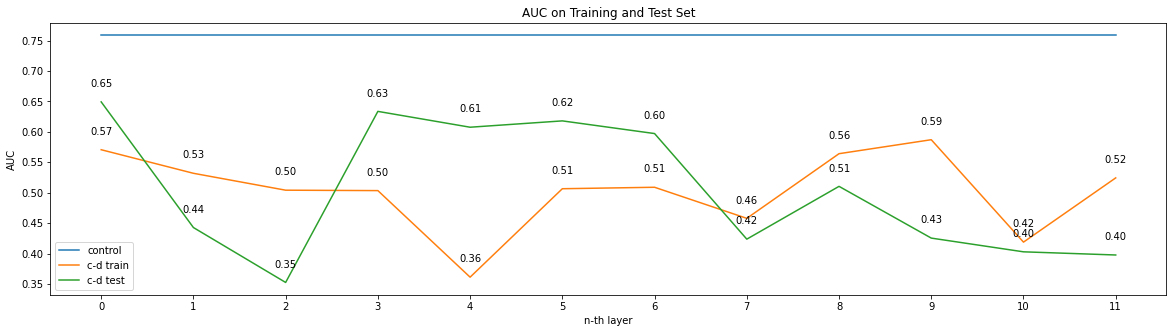

Pearson correction coeffificent: -0.027570322179161232
p-value: 0.9322198778245194


In [10]:
share = 25
layer0_25 = get_aucs_list(share, 0)
layer1_25 = get_aucs_list(share, 1)
layer2_25 = get_aucs_list(share, 2)
layer3_25 = get_aucs_list(share, 3)
layer4_25 = get_aucs_list(share, 4)
layer5_25 = get_aucs_list(share, 5)
layer6_25 = get_aucs_list(share, 6)
layer7_25 = get_aucs_list(share, 7)
layer8_25 = get_aucs_list(share, 8)
layer9_25 = get_aucs_list(share, 9)
layer10_25 = get_aucs_list(share, 10)
layer11_25 = get_aucs_list(share, 11)
train_auc_25 = [layer0_25[0], layer1_25[0], layer2_25[0], layer3_25[0], layer4_25[0], layer5_25[0],
                layer6_25[0], layer7_25[0], layer8_25[0], layer9_25[0], layer10_25[0], layer11_25[0]]
calculate_and_plot("../cache-epochs-100-share-25-style-zero/*.json", train_auc_25)

### Zeroing 50% Attention Heads

100 epochs bootstrap CI for layer 0: [0.5336076817558298, 0.5336076817558298]
100 epochs bootstrap CI for layer 1: [0.4972565157750343, 0.4972565157750343]
100 epochs bootstrap CI for layer 2: [0.5438957475994514, 0.5438957475994514]
100 epochs bootstrap CI for layer 3: [0.4619341563786008, 0.4619341563786008]
100 epochs bootstrap CI for layer 4: [0.3768861454046639, 0.3768861454046639]
100 epochs bootstrap CI for layer 5: [0.4674211248285322, 0.4674211248285322]
100 epochs bootstrap CI for layer 6: [0.5552126200274348, 0.5552126200274348]
100 epochs bootstrap CI for layer 7: [0.4615912208504801, 0.4615912208504801]
100 epochs bootstrap CI for layer 8: [0.6875857338820303, 0.6875857338820303]
100 epochs bootstrap CI for layer 9: [0.48525377229080935, 0.48525377229080935]
100 epochs bootstrap CI for layer 10: [0.4063786008230452, 0.4063786008230452]
100 epochs bootstrap CI for layer 11: [0.4633058984910837, 0.4633058984910837]
0.75


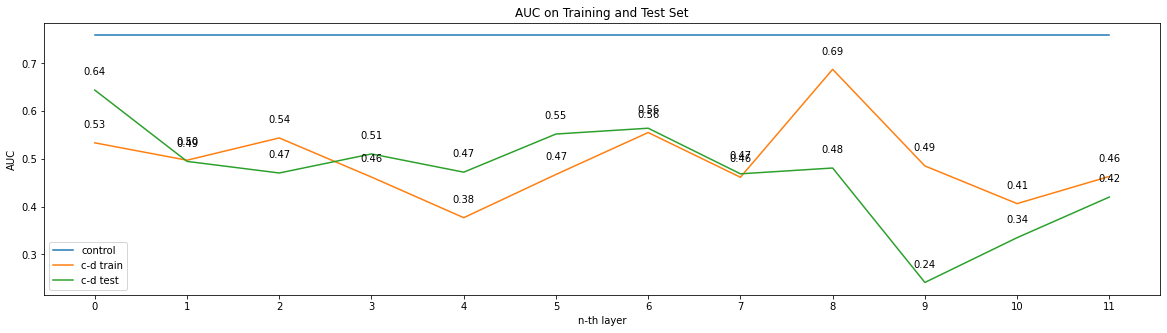

Pearson correction coeffificent: 0.286870557545519
p-value: 0.3659768943762878


In [11]:
share = 50
layer0_50 = get_aucs_list(share, 0)
layer1_50 = get_aucs_list(share, 1)
layer2_50 = get_aucs_list(share, 2)
layer3_50 = get_aucs_list(share, 3)
layer4_50 = get_aucs_list(share, 4)
layer5_50 = get_aucs_list(share, 5)
layer6_50 = get_aucs_list(share, 6)
layer7_50 = get_aucs_list(share, 7)
layer8_50 = get_aucs_list(share, 8)
layer9_50 = get_aucs_list(share, 9)
layer10_50 = get_aucs_list(share, 10)
layer11_50 = get_aucs_list(share, 11)
train_auc_50 = [layer0_50[0], layer1_50[0], layer2_50[0], layer3_50[0], layer4_50[0], layer5_50[0],
                layer6_50[0], layer7_50[0], layer8_50[0], layer9_50[0], layer10_50[0], layer11_50[0]]
calculate_and_plot("../cache-epochs-100-share-50-style-zero/*.json", train_auc_50)

### Shuffling 100% Attention Heads

100 epochs bootstrap CI for layer 0: [0.5517832647462277, 0.5517832647462277]
100 epochs bootstrap CI for layer 1: [0.4818244170096022, 0.4818244170096022]
100 epochs bootstrap CI for layer 2: [0.42866941015089166, 0.42866941015089166]
100 epochs bootstrap CI for layer 3: [0.5205761316872427, 0.5205761316872427]
100 epochs bootstrap CI for layer 4: [0.41426611796982166, 0.41426611796982166]
100 epochs bootstrap CI for layer 5: [0.4790809327846365, 0.4790809327846365]
100 epochs bootstrap CI for layer 6: [0.5099451303155006, 0.5099451303155006]
100 epochs bootstrap CI for layer 7: [0.4886831275720165, 0.4886831275720165]
100 epochs bootstrap CI for layer 8: [0.5120027434842249, 0.5120027434842249]
100 epochs bootstrap CI for layer 9: [0.4255829903978052, 0.4255829903978052]
100 epochs bootstrap CI for layer 10: [0.37722908093278457, 0.37722908093278457]
100 epochs bootstrap CI for layer 11: [0.38443072702331954, 0.38443072702331954]
0.75


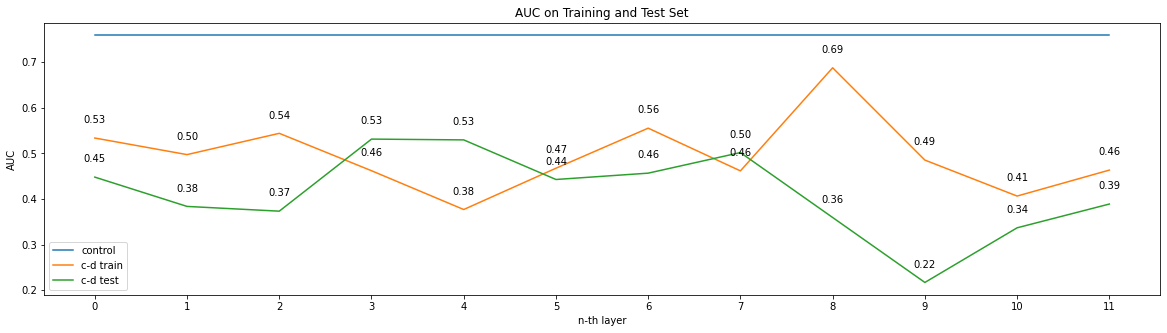

Pearson correction coeffificent: -0.25672289355450156
p-value: 0.42054784261791245


In [12]:
share = 100
layer0_100 = get_aucs_list(share, 0)
layer1_100 = get_aucs_list(share, 1)
layer2_100 = get_aucs_list(share, 2)
layer3_100 = get_aucs_list(share, 3)
layer4_100 = get_aucs_list(share, 4)
layer5_100 = get_aucs_list(share, 5)
layer6_100 = get_aucs_list(share, 6)
layer7_100 = get_aucs_list(share, 7)
layer8_100 = get_aucs_list(share, 8)
layer9_100 = get_aucs_list(share, 9)
layer10_100 = get_aucs_list(share, 10)
layer11_100 = get_aucs_list(share, 11)
train_auc_100 = [layer0_100[0], layer1_100[0], layer2_100[0], layer3_100[0], layer4_100[0], layer5_100[0],
                layer6_100[0], layer7_100[0], layer8_100[0], layer9_100[0], layer10_100[0], layer11_100[0]]
calculate_and_plot("../cache-epochs-100-share-100-style-zero/*.json", train_auc_50)